In [432]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.stats
import scipy.io
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import maximum_filter1d
from scipy.ndimage.filters import minimum_filter1d
from six.moves import urllib
import os
import sklearn.decomposition
import warnings
warnings.simplefilter('ignore')

# create dataset and discrete classification
# y = x + gaussian random noise
# => latent variable is identity line
N = 100
x = np.random.random((N,))
y = x + .2*np.random.randn(N)

x = np.vstack((x,y))
cm = np.array([[1,0,0],[0,0,1]])
cms = np.zeros((N,3))
cms[x[0,:]>.5,:] = cm[0,:]
cms[x[0,:]<=.5,:] = cm[1,:]

# download 2-photon data (if not already downloaded)
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    response = urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy');
    f=open('data/mesoscope_activity.npy','wb')
    f.write(response.read())
    f.close()
    
# load downloaded data
dat = np.load('data/mesoscope_activity.npy')
dat = dat.item()
sp  = dat['spks']
xyloc = dat['xyloc']

In [447]:
dat = scipy.io.loadmat('D:/grive/10krecordings/spontData/spont_M150824_MP019_2016-04-05.mat', squeeze_me=True)


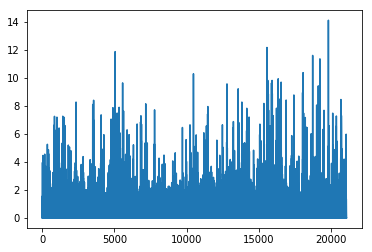

In [457]:
f = dat['Fsp'][10,:]
sp = dat['Fsp']
# normalize stddev's of cells
sp /= sp.std(axis=1)[:,np.newaxis]
plt.plot(f)
plt.show()

In [290]:
m1 = scipy.io.loadmat('../lecture_2/data/m1_stevenson_2011.mat', squeeze_me=True)
sp = m1['spikes']
m1['time'] = m1['time'].squeeze()
tbin = np.diff(m1['time']).mean()
handpos = m1['handPos']

In [449]:
# sp is neurons x timepts, find first PC
# mean center data
sp_sub  = sp - sp.mean(axis=1)[:,np.newaxis]
# compute principal components
sv,u  = scipy.sparse.linalg.eigsh(sp_sub @ sp_sub.T,k=100)
v = np.diag(sv**-0.5) @ u.T @ sp_sub
# low-dimensional approximation:
sp_lowd = ((sp_sub.T @ u) @ u.T).T

In [450]:
# how good is our prediction?
def variance_explained(y,x,w):
    ypred = x @ w
    varres = ((y - ypred)**2).mean()
    varexp = 1 - varres / y[:-1].var()
    return varexp

(10, 10)


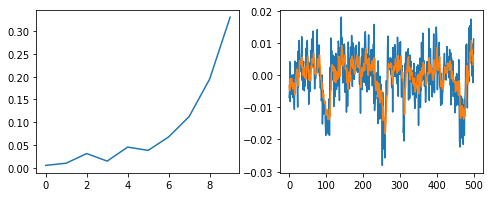

0.4852103174478295


In [451]:
##### let's predict the first principal component from its history
v1 = v[-1,:] + 5e-3*np.random.randn(v.shape[1])
v1 -= v1.mean()
nt = v1.size

# let's make windows of size k (where k is how much history we consider)
k = 10
x = np.zeros((nt-k-1,k+1))
for n in range(nt-k-1):
    x[n,:] = v1[n:n+k+1]
    
# linear regression of predictors (window data) to predicted (each timept in the future)
y = x[:, k]
x = x[:, :k]
covX = x.T @ x / x.shape[0]
print(covX.shape)
w = np.linalg.solve(covX, x.T @ y / x.shape[0])

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1)
ax.plot(w)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(y[:500])
ax2.plot(x[:500,:] @ w)
plt.show()

print(variance_explained(y,x,w))

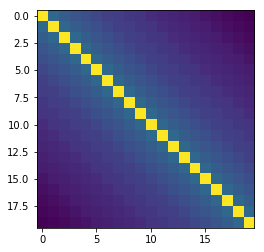

In [430]:
# the covariance in time is a circulant matrix which reflects the autocorrelation function
plt.imshow(covX)
plt.show()

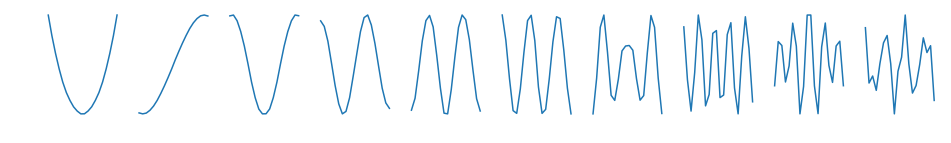

In [431]:
# circulant matrices have PCs which are Fourier modes
svx,ux = scipy.sparse.linalg.eigsh(covX,k=covX.shape[1])
fig = plt.figure(figsize=(16,2))
for k in range(10):
    ax = fig.add_subplot(1,10,k+1)
    ax.plot(ux[:,ux.shape[1]-1-k])
    ax.axis('off')

In [480]:
from scipy.ndimage.filters import convolve1d

expfilt = np.exp(np.arange(0,-8,-1)/2)
#expfilt /= expfilt.sum()
# filter each neuron's timecourse with an exponential filter
spexp = convolve1d(sp, expfilt, axis=1)

(11983, 21055)


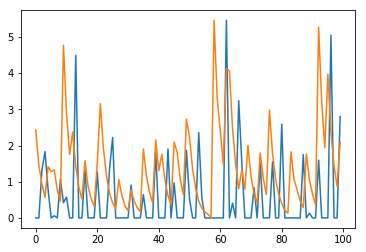

In [481]:
plt.plot(sp[1,:100])
plt.plot(spexp[1,:100])
print(spexp.shape)